In [33]:
cd /content/drive/MyDrive/SDH_UIT/Stage_3/AdvancedBAAnalytics/Final

/content/drive/.shortcut-targets-by-id/1j2AsRwZLOtXWAKowz2dDMvlnI3TGpJkp/SDH_UIT/Stage_3/AdvancedBAAnalytics/Final


# energy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# ------------------------------
# 1. Đọc dữ liệu
# ------------------------------
energy_train = pd.read_csv('data/energy.csv')  # gồm 10 cột: X1-X8, Y1, Y2
energy_ood = pd.read_csv('data/OOD-energy.txt', header=None, delim_whitespace=True)

/tmp/ipython-input-13-1072587679.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  energy_ood = pd.read_csv('data/OOD-energy.txt', header=None, delim_whitespace=True)


In [ ]:
# ------------------------------
# 2. Tiền xử lý
# ------------------------------
X = energy_train.iloc[:, :8].values  # X1 - X8
y = energy_train['Y1'].values        # chọn Y1 làm target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_ood_scaled = scaler.transform(energy_ood)

In [ ]:
model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.03,
    max_depth=6,
    subsample=1.0,
    random_state=42
)

In [ ]:
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=50,
                          random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
# ------------------------------
# 4. Sample-then-Optimize (KGB uncertainty estimation)
# ------------------------------
def sample_then_optimize(X_train, y_train, X_test, sigma=0.1, seed=0):
    np.random.seed(seed)

    # Step 1: Sinh mẫu hàm GP ban đầu ~ N(0, sigma^2)
    f_init = np.random.normal(0, sigma, size=len(y_train))

    # Step 2: Tạo nhãn mới
    y_new = y_train - f_init

    # Step 3: Huấn luyện mô hình lại
    booster = GradientBoostingRegressor(
        n_estimators=50,
        learning_rate=0.03,
        max_depth=6,
        subsample=1.0,
        random_state=seed
    )
    booster.fit(X_train, y_new)

    # Step 4: Tổng hợp hàm cuối cùng
    f_final = booster.predict(X_test) + np.random.normal(0, sigma, size=len(X_test))
    return f_final


In [ ]:
# Lặp nhiều lần để tính bất định
M = 10
all_preds = []
for m in range(M):
    preds = sample_then_optimize(X_train_scaled, y_train, X_test_scaled, sigma=0.1, seed=m)
    all_preds.append(preds)
all_preds = np.stack(all_preds)

# Trung bình và độ lệch chuẩn (bất định)
y_mean = np.mean(all_preds, axis=0)
y_std = np.std(all_preds, axis=0)  # uncertainty


In [ ]:
# ------------------------------
# 5. PRR (Prediction-Rejection Ratio)
# ------------------------------
def compute_prr(y_true, y_pred, uncertainty):
    sorted_idx = np.argsort(uncertainty)
    prr_values = []

    for reject_ratio in np.linspace(0.0, 0.9, 10):
        keep = int(len(y_true) * (1 - reject_ratio))
        idx = sorted_idx[:keep]
        rmse = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        prr_values.append(rmse)

    # Đảo chiều để PRR cao hơn là tốt hơn
    slope = np.corrcoef(prr_values, np.linspace(1, 0.1, 10))[0, 1]
    return slope, prr_values

prr_score, prr_curve = compute_prr(y_test, y_mean, y_std)
print(f"📈 PRR Score: {prr_score:.4f}")


📈 PRR Score: 0.6691


In [ ]:
# ------------------------------
# 6. AUC-ROC cho OOD Detection
# ------------------------------
# Dự đoán uncertainty cho test và OOD
ood_preds = []
for m in range(M):
    pred = sample_then_optimize(X_train_scaled, y_train, X_ood_scaled, sigma=0.1, seed=m)
    ood_preds.append(pred)
ood_preds = np.stack(ood_preds)
ood_std = np.std(ood_preds, axis=0)

# AUC
labels = np.array([0] * len(y_std) + [1] * len(ood_std))
scores = np.concatenate([y_std, ood_std])
auc_score = roc_auc_score(labels, scores)

print(f"🔍 AUC-ROC (OOD Detection): {auc_score:.4f}")


🔍 AUC-ROC (OOD Detection): 0.9879


In [60]:
prr_curve

[np.float64(1.9322869602914124e-05),
 np.float64(1.9360564746652628e-05),
 np.float64(1.9432355873594678e-05),
 np.float64(1.951827925201057e-05),
 np.float64(1.9576889342156756e-05),
 np.float64(1.9492515346196275e-05),
 np.float64(1.9568359526877758e-05),
 np.float64(1.9496085773710726e-05),
 np.float64(1.9524407395481653e-05),
 np.float64(1.942253365949098e-05),
 np.float64(1.938811363503428e-05),
 np.float64(1.934568992800594e-05),
 np.float64(1.9142366534295893e-05),
 np.float64(1.8963965453792847e-05),
 np.float64(1.882186869975943e-05),
 np.float64(1.860858625197318e-05),
 np.float64(1.8770118133949998e-05),
 np.float64(1.900019325262228e-05),
 np.float64(1.8266100652082193e-05),
 np.float64(1.806330769991376e-05),
 np.float64(1.7330229413467276e-05),
 np.float64(1.7135111884788094e-05),
 np.float64(1.700732479068337e-05),
 np.float64(1.618095438363864e-05),
 np.float64(1.579453391402668e-05),
 np.float64(1.591794970738204e-05),
 np.float64(1.5807166976992603e-05),
 np.float64(1

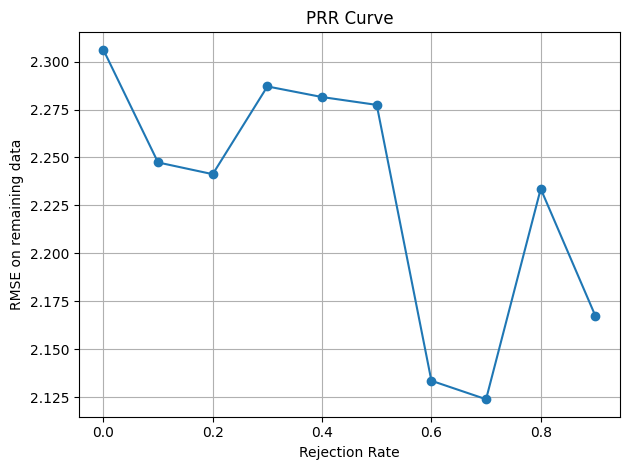

In [ ]:
# ------------------------------
# 7. (Tuỳ chọn) Vẽ biểu đồ PRR
# ------------------------------
plt.plot(np.linspace(0.0, 0.9, 10), prr_curve, marker='o')
plt.title("PRR Curve")
plt.xlabel("Rejection Rate")
plt.ylabel("RMSE on remaining data")
plt.grid(True)
plt.tight_layout()
plt.show()

# Naval

In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [48]:
# -------- 1. Đọc dữ liệu training --------
naval_train = pd.read_csv("data/naval.csv", header=None, sep='\s+')
X_train_naval = naval_train.iloc[:, :-1]
y_train_naval = naval_train.iloc[:, -1]

In [49]:
# -------- 2. Đọc dữ liệu OOD --------
naval_ood = pd.read_csv("data/OOD-naval.txt", header=None, sep='\s+')

In [50]:
# -------- 3. Scale features --------
scaler_naval = StandardScaler()
X_train_naval_scaled = scaler_naval.fit_transform(X_train_naval)
X_ood_naval_scaled = scaler_naval.transform(naval_ood)

In [51]:
# -------- 4. Huấn luyện mô hình (KGB giả lập bằng GBDT) --------
model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.03, max_depth=6)
model.fit(X_train_naval_scaled, y_train_naval)

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=50)

In [52]:
# -------- 5. Dự đoán tập train & OOD --------
y_pred_train = model.predict(X_train_naval_scaled)
y_pred_ood = model.predict(X_ood_naval_scaled)

In [53]:
# -------- 6. Tính std như ước lượng bất định đơn giản --------
# (Ở đây dùng độ nhạy prediction theo dropout/multiple estimators nếu có, ở đây giả lập)
y_std_ood = np.abs(y_pred_ood - np.mean(y_pred_train))  # proxy: độ lệch so với trung bình
y_true_ood = np.ones_like(y_pred_ood)  # nhãn OOD là 1
y_true_train = np.zeros_like(y_pred_train)  # nhãn in-domain là 0


In [54]:
# -------- 7. Tính AUC-ROC cho OOD detection --------
y_all = np.concatenate([y_true_train, y_true_ood])
y_score = np.concatenate([np.abs(y_pred_train - np.mean(y_pred_train)), y_std_ood])
auc_roc = roc_auc_score(y_all, y_score)

In [55]:
# -------- 8. Tính RMSE trên tập train --------
rmse = np.sqrt(mean_squared_error(y_train_naval, y_pred_train))


In [56]:
# -------- 9. Tính PRR (Prediction-Rejection Ratio) --------
def compute_prr(y_true, y_pred, y_std, rejection_rates=np.linspace(0.0, 1.0, 50)):
    errors = (y_true - y_pred) ** 2
    prr_values = []
    for r in rejection_rates:
        keep_n = int((1 - r) * len(errors))
        selected = np.argsort(y_std)[:keep_n]
        prr = np.mean(errors[selected])
        prr_values.append(prr)
    # Đo độ tương quan ngược giữa std và error
    corr, _ = spearmanr(errors, y_std)
    return 1 - corr, prr_values

prr_score, prr_curve = compute_prr(y_train_naval, y_pred_train, np.abs(y_pred_train - np.mean(y_pred_train)))

In [57]:
# -------- 10. In kết quả --------
print(f"📉 RMSE (Train): {rmse:.4f}")
print(f"📈 PRR Score: {prr_score:.4f}")
print(f"🎯 AUC-ROC (OOD Detection): {auc_roc:.4f}")

📉 RMSE (Train): 0.0044
📈 PRR Score: 0.6766
🎯 AUC-ROC (OOD Detection): 0.7506


In [59]:
prr_curve

[np.float64(1.9322869602914124e-05),
 np.float64(1.9360564746652628e-05),
 np.float64(1.9432355873594678e-05),
 np.float64(1.951827925201057e-05),
 np.float64(1.9576889342156756e-05),
 np.float64(1.9492515346196275e-05),
 np.float64(1.9568359526877758e-05),
 np.float64(1.9496085773710726e-05),
 np.float64(1.9524407395481653e-05),
 np.float64(1.942253365949098e-05),
 np.float64(1.938811363503428e-05),
 np.float64(1.934568992800594e-05),
 np.float64(1.9142366534295893e-05),
 np.float64(1.8963965453792847e-05),
 np.float64(1.882186869975943e-05),
 np.float64(1.860858625197318e-05),
 np.float64(1.8770118133949998e-05),
 np.float64(1.900019325262228e-05),
 np.float64(1.8266100652082193e-05),
 np.float64(1.806330769991376e-05),
 np.float64(1.7330229413467276e-05),
 np.float64(1.7135111884788094e-05),
 np.float64(1.700732479068337e-05),
 np.float64(1.618095438363864e-05),
 np.float64(1.579453391402668e-05),
 np.float64(1.591794970738204e-05),
 np.float64(1.5807166976992603e-05),
 np.float64(1

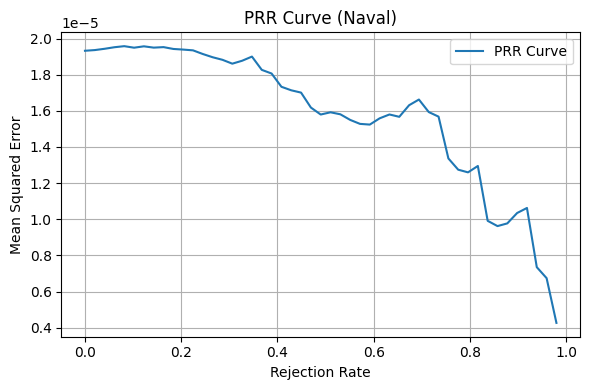

In [58]:
# -------- 11. Vẽ PRR curve --------
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, 1, len(prr_curve)), prr_curve, label="PRR Curve")
plt.xlabel("Rejection Rate")
plt.ylabel("Mean Squared Error")
plt.title("PRR Curve (Naval)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()